In [1]:
import torch
import geospaNN
import numpy as np
import time
import pandas as pd
import seaborn as sns
import random

import matplotlib
import matplotlib.pyplot as plt

path = '../data/Output/'

R[write to console]: Loading required package: BRISC

R[write to console]: Loading required package: RANN

R[write to console]: Loading required package: parallel

R[write to console]: Loading required package: rdist

R[write to console]: Loading required package: matrixStats

R[write to console]: Loading required package: pbapply

R[write to console]: The ordering of inputs x (covariates) and y (response) in BRISC_estimation has been changed BRISC 1.0.0 onwards.
  Please check the new documentation with ?BRISC_estimation.



R package: BRISC installed


/Users/zhanwentao/opt/anaconda3/envs/NN/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def f5(X): return (10 * np.sin(np.pi * X[:, 0] * X[:, 1]) + 20 * (X[:, 2] - 0.5) ** 2 + 10 * X[:, 3] + 5 * X[:, 4]) / 6
def f1(X): return 10 * np.sin(2 * np.pi * X)
    
sigma = 5
phi = 0.3
tau = 0.01
theta = torch.tensor([sigma, phi / np.sqrt(2), tau])

p = 1;
funXY = f1

n = 1000
b = 10
nn = 20
batch_size = 50

In [3]:
rho = np.sqrt(0.7)  # AR(1) coefficient #0.7
sigma_AR = 5  # Standard deviation of noise
x0 = 0  # Initial value

# Simulate white noise
np.random.seed(2024) #2025
epsilon = np.random.normal(0, sigma_AR, n)

# Initialize the process
corerr = np.zeros(n)
corerr[0] = x0

# Generate AR(1) process
for t in range(1, n):
    corerr[t] = rho * corerr[t-1] + epsilon[t]

coord = torch.zeros((n,2))
coord[:,0] = torch.tensor(range(n))/100

#corerr = corerr - corerr.mean()

In [5]:
torch.manual_seed(2024) #2025
X, _, _, _, _ = geospaNN.Simulation(n, p, nn, funXY, theta, range=[0, b])
Y = funXY(X) + corerr.reshape((-1,1))
Y = Y.reshape(-1)

random.seed(2024)
X, Y, coord, _ = geospaNN.spatial_order(X.float(), Y.float(), coord, method='max-min')
data = geospaNN.make_graph(X, Y, coord, nn)

torch.manual_seed(2024)
np.random.seed(0)
data_train, data_val, data_test = geospaNN.split_data(X, Y, coord, neighbor_size=nn,
                                                      test_proportion=0.2)

In [6]:
torch.manual_seed(2024)
mlp_nn = torch.nn.Sequential(
    torch.nn.Linear(p, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 1),
)
trainer_nn = geospaNN.nn_train(mlp_nn, lr=0.01, min_delta=0.001)
training_log = trainer_nn.train(data_train, data_val, data_test, seed = 2025)
theta0 = geospaNN.theta_update(mlp_nn(data_train.x).squeeze() - data_train.y, 
                               data_train.pos, neighbor_size=20)

Epoch 00028: reducing learning rate of group 0 to 5.0000e-03.
Epoch 00041: reducing learning rate of group 0 to 2.5000e-03.
INFO: Early stopping
End at epoch44
---------------------------------------- 
	Ordering Coordinates 
----------------------------------------
	Model description
----------------------------------------
BRISC model fit with 600 observations.

Number of covariates 1 (including intercept if specified).

Using the exponential spatial correlation model.

Using 15 nearest neighbors.



Source not compiled with OpenMP support.
----------------------------------------
	Building neighbor index
----------------------------------------
	Performing optimization
----------------------------------------
	Processing optimizers
----------------------------------------
Theta estimated as
[7.47109114e+01 2.15550560e+01 1.00000000e-03]


In [7]:
torch.manual_seed(2024)
mlp_nngls = torch.nn.Sequential(
    torch.nn.Linear(p, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 1),
)
model = geospaNN.nngls(p=p, neighbor_size=nn, coord_dimensions=2, mlp=mlp_nngls, 
                       theta=torch.tensor(theta0))
trainer_nngls = geospaNN.nngls_train(model, lr=0.1, min_delta=0.001)
training_log = trainer_nngls.train(data_train, data_val, data_test, epoch_num= 200, 
                                   Update_init=20, Update_step=5, seed = 2025)
theta1 = geospaNN.theta_update(mlp_nngls(data_train.x).squeeze() - data_train.y,
                               data_train.pos, neighbor_size=20)

---------------------------------------- 
	Ordering Coordinates 
----------------------------------------
	Model description
----------------------------------------
BRISC model fit with 600 observations.

Number of covariates 1 (including intercept if specified).

Using the exponential spatial correlation model.

Using 15 nearest neighbors.



Source not compiled with OpenMP support.
----------------------------------------
	Building neighbor index
----------------------------------------
	Performing optimization
----------------------------------------
	Processing optimizers
----------------------------------------
Theta estimated as
[7.59856517e+01 2.17174060e+01 4.19267552e-02]
to
[7.59856517e+01 2.17174060e+01 4.19267552e-02]
Epoch 00022: reducing learning rate of group 0 to 5.0000e-02.
---------------------------------------- 
	Ordering Coordinates 
----------------------------------------
	Model description
----------------------------------------
BRISC model fit with 600 observ

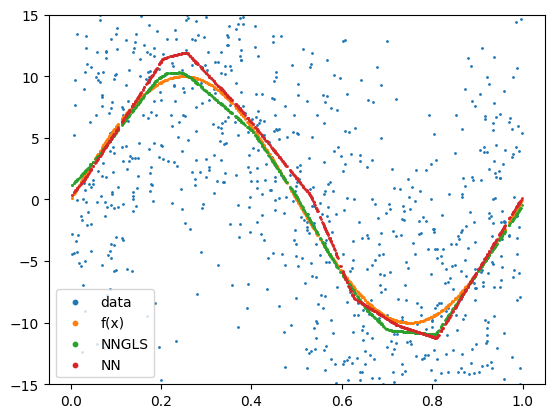

In [8]:
estimate = model.estimate(X)
plt.clf()
plt.scatter(X.detach().numpy(), Y.detach().numpy(), s=1, label='data')
plt.scatter(X.detach().numpy(), funXY(X.detach().numpy()), s=1, label='f(x)')
plt.scatter(X.detach().numpy(), estimate, s=1, label='NNGLS')
plt.scatter(X.detach().numpy(), mlp_nn(X).detach().numpy(), s=1, label='NN')
lgnd = plt.legend()
plt.ylim([-15, 15])
for handle in lgnd.legend_handles:
    handle.set_sizes([10.0])
plt.savefig(path + 'Estimation_AR.png')

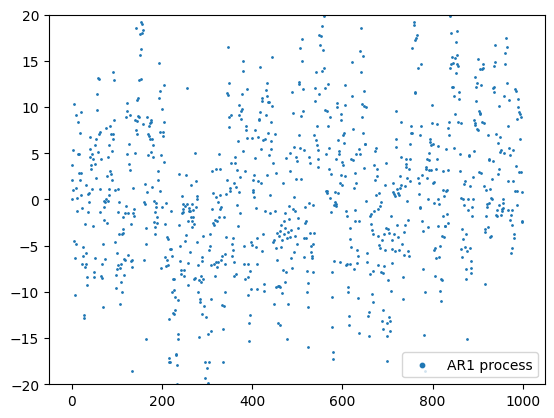

In [120]:
estimate = model.estimate(X)
plt.clf()
plt.scatter(range(n), corerr, s=1, label='AR1 process')
plt.ylim([-20, 20])
lgnd = plt.legend()
for handle in lgnd.legend_handles:
    handle.set_sizes([10.0])
plt.savefig(path + 'AR.png')

In [121]:
def RMSE(x,y):
    x = x.reshape(-1)
    y = y.reshape(-1)
    n = x.shape[0]
    return(np.sqrt(np.sum(np.square(x-y))/n))


In [122]:
RMSE(estimate.detach().numpy(), funXY(X).reshape(-1).detach().numpy())

0.5564364208770987

In [123]:
RMSE(mlp_nn(X).detach().numpy(), funXY(X).reshape(-1).detach().numpy())

0.9576370212929225